In [1]:
import random
import pandas as pd


city_prices = {
    'Bordeaux': 4045,
    'Lyon': 4547,
    'Toulouse': 3278
}


def make_houses(n_houses, city_prices):

    cities = [city for city in city_prices for _ in range(n_houses)]

    sizes = [round(random.gauss(200, 50)) for _ in range(len(cities))]

    prices = [
        round(random.uniform(0.8, 1.2) * city_prices[city] * size)
        for city, size in zip(cities, sizes)
    ]

    return pd.DataFrame({
        'city': cities,
        'size': sizes,
        'price': prices
    })

In [13]:
houses = make_houses(100, city_prices)
houses.sample(5)

,city,size,price
196,Lyon,257,1292818
74,Bordeaux,174,772024
188,Lyon,91,494816
181,Lyon,224,907355
235,Toulouse,112,320761


Text(0.5, 1.0, '100 simulated houses')

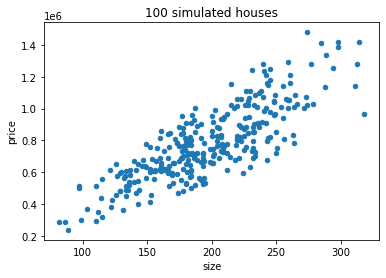

In [3]:
ax = houses.plot.scatter(x='size', y='price')
ax.set_title('100 simulated houses')

In [4]:
def a_dominates_b(a, b, to_min, to_max):

    n_better = 0

    for f in to_min:
        if a[f] > b[f]:
            return False
        n_better += a[f] < b[f]

    for f in to_max:
        if a[f] < b[f]:
            return False
        n_better += a[f] > b[f]

    if n_better > 0:
        return True
    return False

In [6]:
def find_skyline_brute_force(df, to_min, to_max):

    rows = df.to_dict(orient='index')

    skyline = set()

    for i in rows:

        dominated = False

        for j in rows:

            if i == j:
                continue

            if a_dominates_b(rows[j], rows[i], to_min, to_max):
                dominated = True
                break

        if not dominated:
            skyline.add(i)

    return pd.Series(df.index.isin(skyline), index=df.index)

Text(0.5, 1.0, 'Houses skyline')

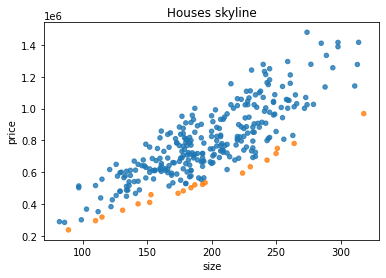

In [7]:
skyline = find_skyline_brute_force(houses, to_min=['price'], to_max=['size'])

colors = skyline.map({True: 'C1', False: 'C0'})
ax = houses.plot.scatter(x='size', y='price', c=colors, alpha=0.8)
ax.set_title('Houses skyline')

In [8]:
def count_diffs(a, b, to_min, to_max):
    n_better = 0
    n_worse = 0

    for f in to_min:
        n_better += a[f] < b[f]
        n_worse += a[f] > b[f]

    for f in to_max:
        n_better += a[f] > b[f]
        n_worse += a[f] < b[f]

    return n_better, n_worse


def find_skyline_bnl(df, to_min, to_max):
    """Finds the skyline using a block-nested loop."""

    rows = df.to_dict(orient='index')

    # Use the first row to initialize the skyline
    skyline = {df.index[0]}

    # Loop through the rest of the rows
    for i in df.index[1:]:

        to_drop = set()
        is_dominated = False

        for j in skyline:

            n_better, n_worse = count_diffs(rows[i], rows[j], to_min, to_max)

            # Case 1
            if n_worse > 0 and n_better == 0:
                is_dominated = True
                break

            # Case 3
            if n_better > 0 and n_worse == 0:
                to_drop.add(j)

        if is_dominated:
            continue

        skyline = skyline.difference(to_drop)
        skyline.add(i)

    return pd.Series(df.index.isin(skyline), index=df.index)

In [9]:
for _ in range(30):
    houses = make_houses(n_houses=random.randint(120, 140), city_prices=city_prices)

    pd.testing.assert_series_equal(
        find_skyline_brute_force(df=houses, to_min=['price'], to_max=['size']),
        find_skyline_bnl(df=houses, to_min=['price'], to_max=['size'])
    )

In [10]:
import time

houses = make_houses(n_houses=5_000, city_prices=city_prices)

tic = time.time()
skyline = find_skyline_brute_force(df=houses, to_min=['price'], to_max=['size'])
print(f'Brute-force took {time.time() - tic:.3f} seconds')

tic = time.time()
skyline = find_skyline_bnl(df=houses, to_min=['price'], to_max=['size'])
print(f'Block nested loop took {time.time() - tic:.3f} seconds')

Brute-force took 11.874 seconds
Block nested loop took 0.271 seconds


Text(0.5, 1.0, 'Running time in seconds of the BNL algorithm')

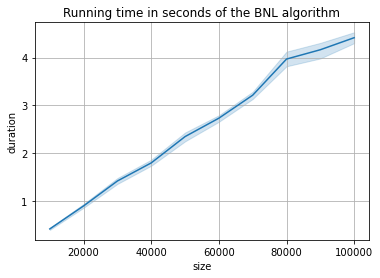

In [12]:
import seaborn as sns
import numpy as np

def measure_time(n):
    houses = make_houses(n_houses=n, city_prices=city_prices)
    tic = time.time()
    skyline = find_skyline_bnl(df=houses, to_min=['price'], to_max=['size'])
    return time.time() - tic

durations = pd.DataFrame([
    {'size': n, 'duration': measure_time(n)}
     for n in np.arange(10000, 110_000, 10000) for i in range(10)
])

ax = sns.lineplot(x='size', y='duration', data=durations)
ax.grid()
ax.set_title('Running time in seconds of the BNL algorithm')